# Implementation of a Long Short Term Memory Neural Network for Sunspot prediction

Why Sunspots?

# Importing libaries

These are the libraries which are necessary to train and run this Neural Network

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn import model_selection
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
torch.manual_seed(123)


cuda:0
2.0.1


# Reading the Data and understanding all elements

The Dataset was obtained from Kaggle. It is a collection of 73000 elements containing data about the presence of sunspots

In [3]:
# Load the CSV data into a pandas DataFrame
sunspot = pd.read_csv('sunspot_data_final.csv')


In [4]:
sunspot.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [5]:
# Display the summary information
sunspot.info()

# Display descriptive statistics of numerical columns
print(sunspot.describe())

# Get the dimensions of the DataFrame
print(sunspot.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73718 entries, 0 to 73717
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                73718 non-null  int64  
 1   Year                      73718 non-null  int64  
 2   Month                     73718 non-null  int64  
 3   Day                       73718 non-null  int64  
 4   Date In Fraction Of Year  73718 non-null  float64
 5   Number of Sunspots        73718 non-null  int64  
 6   Standard Deviation        73718 non-null  float64
 7   Observations              73718 non-null  int64  
 8   Indicator                 73718 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.1 MB
         Unnamed: 0          Year         Month           Day  \
count  73718.000000  73718.000000  73718.000000  73718.000000   
mean   36858.500000   1918.416750      6.518896     15.729347   
std    21280.697909     58.264401      3.4

In [6]:
# Access the column names
features = sunspot.columns

# Print the column names
print(features)


Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Date In Fraction Of Year',
       'Number of Sunspots', 'Standard Deviation', 'Observations',
       'Indicator'],
      dtype='object')


In [7]:
# Display the first few values of a specific column
print(sunspot['Year'].head())


0    1818
1    1818
2    1818
3    1818
4    1818
Name: Year, dtype: int64


In [8]:
# This is the first ecent
first_event = sunspot.head(1)
print(first_event)

   Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
0           0  1818      1    1                  1818.001                  -1   

   Standard Deviation  Observations  Indicator  
0                -1.0             0          1  


In [9]:
# this is how the First event is displayed as a list
first_event_list = first_event.values.tolist()[0]
print(first_event_list)


[0.0, 1818.0, 1.0, 1.0, 1818.001, -1.0, -1.0, 0.0, 1.0]


In [10]:
# Filter the data based on the condition
filtered_data = sunspot[(sunspot['Number of Sunspots'] < 1) | (sunspot['Number of Sunspots'] > 1)]

# Display the filtered data
print(filtered_data)

       Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  \
0               0  1818      1    1                  1818.001   
1               1  1818      1    2                  1818.004   
2               2  1818      1    3                  1818.007   
3               3  1818      1    4                  1818.010   
4               4  1818      1    5                  1818.012   
...           ...   ...    ...  ...                       ...   
73713       73713  2019     10   27                  2019.821   
73714       73714  2019     10   28                  2019.823   
73715       73715  2019     10   29                  2019.826   
73716       73716  2019     10   30                  2019.829   
73717       73717  2019     10   31                  2019.832   

       Number of Sunspots  Standard Deviation  Observations  Indicator  
0                      -1                -1.0             0          1  
1                      -1                -1.0             0          1  


In [11]:
feature_map = {}

# Iterate over the column names and their corresponding data
for column in filtered_data.columns:
    feature_map[column] = filtered_data[column].values

# Print the feature map
for feature_name, feature_data in feature_map.items():
    print(f"{feature_name}: {feature_data}")

Unnamed: 0: [    0     1     2 ... 73715 73716 73717]
Year: [1818 1818 1818 ... 2019 2019 2019]
Month: [ 1  1  1 ... 10 10 10]
Day: [ 1  2  3 ... 29 30 31]
Date In Fraction Of Year: [1818.001 1818.004 1818.007 ... 2019.826 2019.829 2019.832]
Number of Sunspots: [-1 -1 -1 ...  0  0  0]
Standard Deviation: [-1. -1. -1. ...  0.  0.  0.]
Observations: [ 0  0  0 ... 30 24 28]
Indicator: [1 1 1 ... 0 0 0]


#Throwback to Third Homework

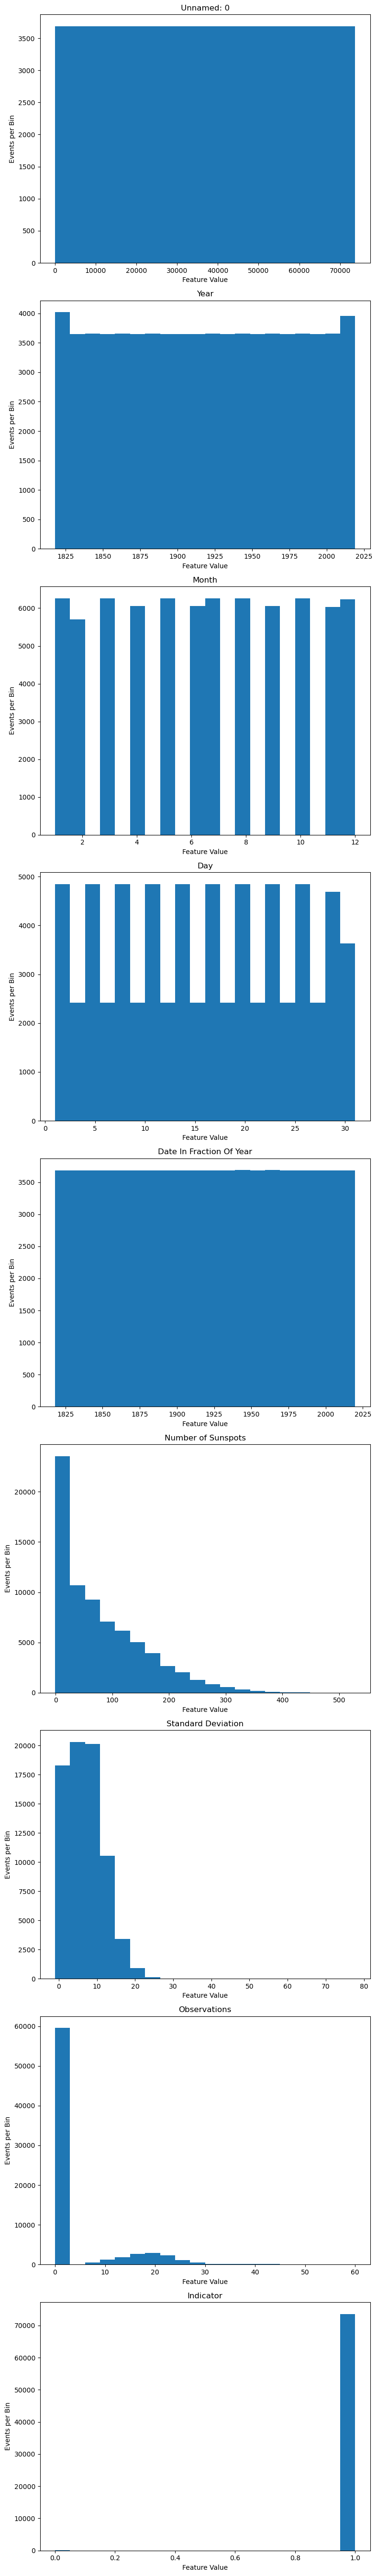

In [12]:
fig, axes = plt.subplots(len(feature_map), 1, figsize=(8, 6 * len(feature_map)))

for i, (feature_name, feature_data) in enumerate(feature_map.items()):
    ax = axes[i]
    ax.hist(feature_data, bins=20)
    ax.set_title(feature_name)
    ax.set_xlabel("Feature Value")
    ax.set_ylabel("Events per Bin")

plt.tight_layout()
plt.show()

#I am confident in these histograms because they are similar to the ones on the original Kaggle. Also this was from the third homework

Now that we understand the elements of this dataset, its time to prepare it for training by the LSTM

# Neural Network Preparations

In [13]:
timeseries = sunspot[["Number of Sunspots"]].values.astype('float32')
time = []
count = []
for x in range(len(timeseries)):
  if timeseries[x] >= 0:
    time.append(x)
    count.append(timeseries[x])

In [14]:
time = np.asarray(time)
training_set = np.asarray(count)

In [15]:
print(len(time))

70471


Text(0, 0.5, 'numberofspots')

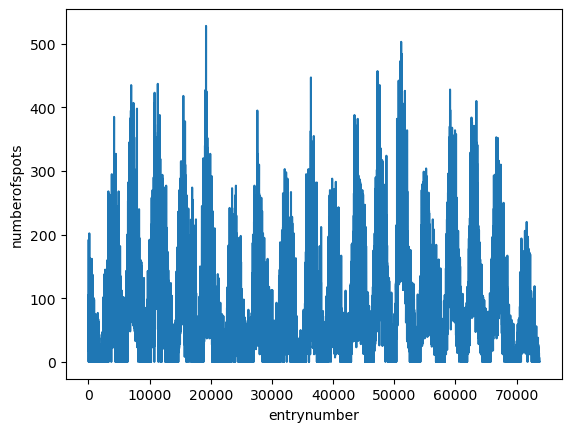

In [16]:
plt.plot(time, count)
plt.xlabel('entrynumber')
plt.ylabel('numberofspots')

#Now this is where the fun stuff begins. I'm naming my Neural Network Teletubbies Sun Baby 

In [17]:
##SLIDING WINDOWS Function
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - pred_length):
        _x = data[i:(i+seq_length)]  # previous seq_length data points
        _y = data[i+seq_length]  # next N data points
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [18]:
#training_data=training_set
sc = MinMaxScaler()
training_data = sc.fit_transform(timeseries)

seq_length = 4
pred_length = 5
x, y = sliding_windows(training_data, seq_length, pred_length)


In [19]:
# Train Test Split: I used 67% of data for my set
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size
train_x, train_y = x[:train_size], y[:train_size]
test_x, test_y = x[train_size:], y[train_size:]


In [20]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=4)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=4)

In [21]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


In [22]:
print("Train Data Shape:", trainX.shape)
print("Train Target Shape:", trainY.shape)
print("Test Data Shape:", testX.shape)
print("Test Target Shape:", testY.shape)


Train Data Shape: torch.Size([49385, 4, 1])
Train Target Shape: torch.Size([49385, 1])
Test Data Shape: torch.Size([24324, 4, 1])
Test Target Shape: torch.Size([24324, 1])


# Training the NN (Teletubbies Sun Baby)

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 4
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [24]:
#Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [25]:
num_epochs = 2000

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(trainX.to(device))
    loss = criterion(outputs, trainY.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            outputs = model(testX.to(device))
            test_loss = criterion(outputs, testY.to(device))
            test_losses.append(test_loss.item())
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")



Epoch 100/2000, Train Loss: 0.0193, Test Loss: 0.0267
Epoch 200/2000, Train Loss: 0.0153, Test Loss: 0.0201
Epoch 300/2000, Train Loss: 0.0068, Test Loss: 0.0054
Epoch 400/2000, Train Loss: 0.0065, Test Loss: 0.0042
Epoch 500/2000, Train Loss: 0.0063, Test Loss: 0.0039
Epoch 600/2000, Train Loss: 0.0060, Test Loss: 0.0036
Epoch 700/2000, Train Loss: 0.0058, Test Loss: 0.0033
Epoch 800/2000, Train Loss: 0.0055, Test Loss: 0.0029
Epoch 900/2000, Train Loss: 0.0052, Test Loss: 0.0025
Epoch 1000/2000, Train Loss: 0.0050, Test Loss: 0.0021
Epoch 1100/2000, Train Loss: 0.0049, Test Loss: 0.0019
Epoch 1200/2000, Train Loss: 0.0048, Test Loss: 0.0018
Epoch 1300/2000, Train Loss: 0.0048, Test Loss: 0.0017
Epoch 1400/2000, Train Loss: 0.0048, Test Loss: 0.0016
Epoch 1500/2000, Train Loss: 0.0048, Test Loss: 0.0016
Epoch 1600/2000, Train Loss: 0.0048, Test Loss: 0.0016
Epoch 1700/2000, Train Loss: 0.0048, Test Loss: 0.0015
Epoch 1800/2000, Train Loss: 0.0048, Test Loss: 0.0015
Epoch 1900/2000, Tr

# Plotting the Loss Curve

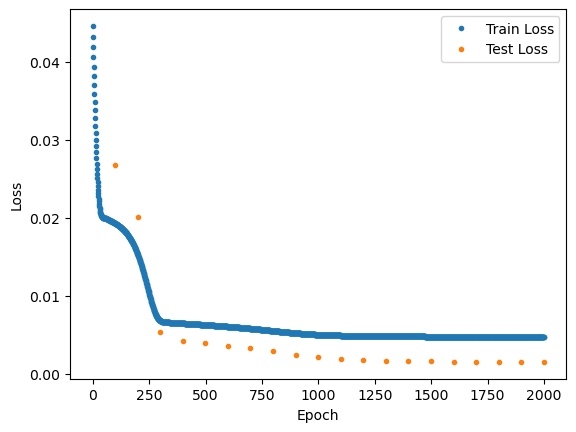

In [26]:
plt.plot(train_losses,'.', label='Train Loss')
plt.plot(range(99, num_epochs, 100), test_losses, '.', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# The loss curve is like a 7.5/10. Basically its better than the Star Wars Sequel Trilogy

# Prediction of future sunspot values

In [53]:
# Prepare the input data
input_data = timeseries[-seq_length:]
input_data = sc.transform(input_data)  # Scale the input data using the MinMaxScaler
input_data = torch.Tensor(input_data).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension


In [54]:
# Perform forward pass and prediction
model.eval()
with torch.no_grad():
    prediction = model(input_data)


In [55]:
# Inverse transform the prediction
prediction = prediction.cpu().numpy()  # Move the prediction to the CPU and convert to NumPy array
prediction = sc.inverse_transform(prediction)  # Inverse transform the prediction


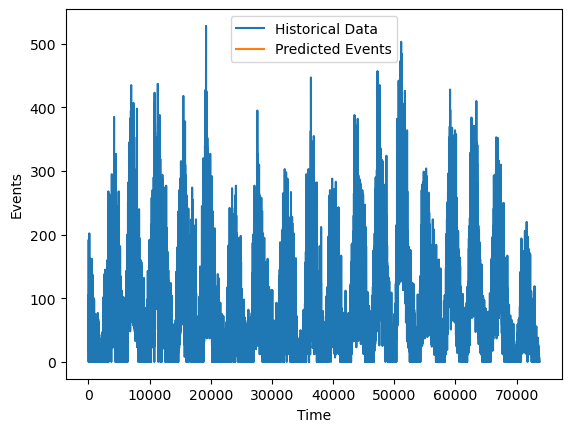

In [56]:
# Create a time array for the predicted time steps corresponding to the predicted events
predicted_time = np.arange(len(timeseries), len(timeseries) + len(prediction))

# Plot the historical data and predicted values
plt.plot(time, count, label='Historical Data')
plt.plot(predicted_time, prediction.flatten(), label='Predicted Events')
plt.xlabel('Time')
plt.ylabel('Events')
plt.legend()
plt.show()

# Error Analysis: Because nothing in Science is Perfect

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_sunspots, predicted_sunspots)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_sunspots, predicted_sunspots)


# The Mean Squared Error measures the average squared difference between the predicted values and the actual values. It provides an overall measure of the model's accuracy.

In [60]:
print(mse)

422.30078


# The Mean Absolute Error measures the average absolute difference between the predicted values and the actual values. It provides a more interpretable measure of the model's performance.

In [61]:
print(rmse)

20.549957


# The Root Mean Squared Error is the square root of the Mean Squared Error and provides a measure of the average magnitude of the errors. It is widely used as it has the same scale as the target variable.

In [62]:
print(mae)

14.882552
